In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
# First, add these imports at the top of your file
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load environment variables
load_dotenv()

# Updated URL list with education resources and reports
urls = [
    # Franklin Cummings Tech programs
    "https://franklincummings.edu/academics/academic-programs/",
    "https://franklincummings.edu/academics/academic-programs/automotive-technology/",
    "https://franklincummings.edu/academics/academic-programs/hvacr/",
    "https://franklincummings.edu/academics/cewp/",
    "https://franklincummings.edu/academics/academic-programs/practical-electricity/",
    "https://franklincummings.edu/academics/academic-programs/renewable-energy-technology/",
    "https://franklincummings.edu/academics/academic-programs/construction-management/",
    "https://franklincummings.edu/academics/academic-programs/mechatronics-technology/",
    "https://franklincummings.edu/academics/academic-programs/engineering-technology/",
    "https://franklincummings.edu/academics/academic-programs/building-energy-management/",
    
    # Clean energy education resources
    "https://www.masscec.com/clean-energy-internships-students",
    "https://cleanenergyeducation.org/",
    "https://cleanenergyeducation.org/curriculum/",
    "https://www.masscec.com/about-us/our-work/workforce-development",
    "https://www.masscec.com/about-us/our-work/workforce-development/workforce-deij",
    "https://joinact.org/resources/resource-library",
    "https://joinact.org/our-work/climate-economy-ecosystem",
    "https://joinact.org/our-work/innovation",
    "https://joinact.org/our-work/workforce-deij",
    
    # Reports
    "https://www.masscec.com/reports/industry-2023/",
    "Powering_the_Future_A_Massachusetts_Clean_Energy_Workforce_Needs_Assessment_Final.pdf",
    "NECEC_2023_Annual_Report.pdf"
]

# Load documents with error handling
docs = []
for url in urls:
    try:
        if url.strip():  # Skip empty URLs
            # Use appropriate loader based on file type
            if url.endswith('.pdf'):
                loader = PyPDFLoader(url)
            else:
                loader = WebBaseLoader(url)
                
            loaded = loader.load()
            if loaded:  # Only append if we got valid documents
                docs.extend(loaded)
    except Exception as e:
        print(f"Error loading {url}: {str(e)}")



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [45]:
import os
from dotenv import load_dotenv
import re
import io
import ipywidgets as widgets
from IPython.display import display
import time  # needed for delays

# Load environment variables from .env
load_dotenv()

# Optional: If you want to set a custom user agent, add this line to your .env file:
# USER_AGENT="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36"

# External Dependencies
try:
    from PyPDF2 import PdfReader
except ImportError:
    print("PyPDF2 is not installed. Install it using 'pip install PyPDF2'.")

try:
    from duckduckgo_search import ddg
except ImportError:
    print("duckduckgo_search is not installed. Install it using 'pip install duckduckgo_search'.")

In [46]:
def safe_ddg_search(query: str, max_results: int = 3, max_length: int = 150, max_retries: int = 3, initial_delay: float = 2.0):
    """
    Perform a safe DuckDuckGo search after sanitizing and truncating the query.
    Implements exponential backoff when a rate-limit error is encountered.

    Parameters:
      query (str): The raw search query.
      max_results (int): Maximum number of results to return.
      max_length (int): Maximum allowed query length.
      max_retries (int): Number of times to retry if a ratelimit error occurs.
      initial_delay (float): Seconds to wait initially before retrying.
      
    Returns:
      list: DuckDuckGo search results or an empty list if the search fails.
    """
    # Remove excessive whitespace and newlines.
    sanitized_query = " ".join(query.split())
    if len(sanitized_query) > max_length:
         sanitized_query = sanitized_query[:max_length]
         
    retries = 0
    delay = initial_delay
    # Use the USER_AGENT from the environment if set, otherwise use a default.
    user_agent = os.getenv("USER_AGENT", "Mozilla/5.0 (Windows NT 10.0; Win64; x64)")
    
    while retries < max_retries:
         try:
              results = ddg(sanitized_query, max_results=max_results, user_agent=user_agent)
              return results
         except Exception as e:
              if "Ratelimit" in str(e):
                   print(f"Error during DuckDuckGo search (attempt {retries+1}/{max_retries}): {e}. Retrying in {delay} seconds...")
                   time.sleep(delay)
                   retries += 1
                   delay *= 2  # Exponential backoff
              else:
                   print(f"Error during DuckDuckGo search: {e}")
                   return []
    print("Max retries exceeded for query.")
    return []

In [47]:
def extract_name(text: str) -> str:
    """
    Naively extract a person’s name from the text.
    (This regex is simplistic and can be improved.)
    """
    match = re.search(r"(?m)^(?P<name>[A-Z][a-z]+(?:\s[A-Z][a-z]+)+)$", text)
    return match.group("name") if match else "Name Not Found"

def extract_phone(text: str) -> str:
    """Extract a phone number from the text."""
    match = re.search(r"\b(\d{3}[-.\s]??\d{3}[-.\s]??\d{4})\b", text)
    return match.group(1) if match else "Phone Not Found"

def extract_linkedin_url(text: str) -> str:
    """Extract a LinkedIn URL from the text."""
    match = re.search(r"(https?://(?:www\.)?linkedin\.com/[^\s]+)", text)
    return match.group(1) if match else "LinkedIn URL Not Found"

def extract_github_url(text: str) -> str:
    """Extract a GitHub URL from the text."""
    match = re.search(r"(https?://(?:www\.)?github\.com/[^\s]+)", text)
    return match.group(1) if match else "GitHub URL Not Found"

def extract_portfolio_url(text: str) -> str:
    """
    Extract a portfolio URL – assumes any URL that is not LinkedIn or GitHub.
    """
    urls = re.findall(r"(https?://[^\s]+)", text)
    for url in urls:
        if "linkedin.com" not in url and "github.com" not in url:
            return url
    return "Portfolio URL Not Found"

def extract_section(text: str, section_title: str) -> str:
    """
    Extract a section of the resume starting from the given section title until the next block 
    of capitalized text or the end. This heuristic may need adjustments for different formats.
    """
    pattern = rf"({section_title}.+?)(?=\n[A-Z][A-Z\s]+\n|$)"
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    return match.group(1).strip() if match else ""

def convert_pdf_text_to_markdown(pdf_text: str) -> str:
    """
    Convert raw PDF text to Markdown by applying simple heuristics:
      - Lines in all uppercase (of sufficient length) are treated as headers.
      - Lines starting with typical bullet symbols are rendered as list items.
    """
    lines = pdf_text.splitlines()
    markdown_lines = []
    for line in lines:
        if line.isupper() and len(line) > 5:
            markdown_lines.append(f"# {line.title()}")
        elif re.match(r"^[\*\-\+]\s", line):
            markdown_lines.append(f"- {line[2:]}")
        else:
            markdown_lines.append(line)
    return "\n".join(markdown_lines)

In [48]:
def enhance_user_profile(resume_text: str) -> dict:
    """
    Extract key details from the resume text, enrich each section by performing a safe 
    DuckDuckGo search, and return an enhanced user profile.
    """
    enhanced_profile = {
        'name': extract_name(resume_text),
        'phone': extract_phone(resume_text),
        'linkedin_url': extract_linkedin_url(resume_text),
        'github_url': extract_github_url(resume_text),
        'portfolio_url': extract_portfolio_url(resume_text),
        'education': extract_section(resume_text, "EDUCATION"),
        'professional_experience': extract_section(resume_text, "PROFESSIONAL EXPERIENCE"),
        'skills': extract_section(resume_text, "SKILLS"),
        'certificates': extract_section(resume_text, "CERTIFICATES"),
        'ddg_search': {}
    }
    
    # Enrich each section with DuckDuckGo search results using safe_ddg_search.
    enhanced_profile['ddg_search']['education_search'] = safe_ddg_search(enhanced_profile['education'])
    enhanced_profile['ddg_search']['experience_search'] = safe_ddg_search(enhanced_profile['professional_experience'])
    enhanced_profile['ddg_search']['skills_search'] = safe_ddg_search(enhanced_profile['skills'])
    
    return enhanced_profile

In [49]:
upload_widget = widgets.FileUpload(
    accept='.txt,.pdf',
    multiple=False,
    description='Upload Resume'
)
display(upload_widget)

def handle_resume_upload(change):
    if change['new']:
        # Handle both tuple and dict formats.
        files = upload_widget.value
        if isinstance(files, tuple):
            file_list = files
        elif isinstance(files, dict):
            file_list = list(files.values())
        else:
            file_list = []

        for file_info in file_list:
            filename = file_info.get("name", "unknown")
            content = file_info.get("content", None)
            if content is None:
                continue

            print(f"\nFile uploaded: {filename}")
            # Process PDF files
            if filename.lower().endswith('.pdf'):
                pdf_stream = io.BytesIO(content)
                reader = PdfReader(pdf_stream)
                resume_text = ""
                for page in reader.pages:
                    resume_text += page.extract_text() + "\n"
                markdown_text = convert_pdf_text_to_markdown(resume_text)
                print("Converted Markdown Content:\n")
                print(markdown_text)
            else:
                resume_text = content.decode('utf-8')
                print("Uploaded Resume Content:\n")
                print(resume_text)
            
            # Build and display the enhanced profile.
            enhanced_profile = enhance_user_profile(resume_text)
            print("\nEnhanced User Profile:")
            print(enhanced_profile)

upload_widget.observe(handle_resume_upload, names='value')

FileUpload(value=(), accept='.txt,.pdf', description='Upload Resume')


File uploaded: Resume_GeorgeNekwaya.pdf
Converted Markdown Content:

George
Nekwaya 
Waltham,
MA
|
781-472-9024 | 
gnekwaya@brandeis.edu
 | 
www.linkedin.com/in/george-nekwaya
| 
portfolio:
www.georgenekwaya.com
# Summary 
Entrepreneurial
and
visionary
business
leader
specializing
in
financial
technology
and
open
banking
solutions.
As
the 
Founder
and
Product
Owner
of
Buffr,
a
pioneering
fintech
startup,
I
am
spearheading
the
development
of
an
innovative 
multi-bank
wallet
and
payment
aggregator
platform
# Education 
Brandeis
International
Business
School
Waltham,
MA 
Master
of
Business
Administration
(STEM-Designated) 
Expected
Graduation:
May
2024
Entrepreneurial
Experience 
Buffr
Inc.
|
Founder 
●
Conceptualized
Buffr's
vision
of
a
unified
dashboard
consolidating
users'
financial
footprint
across
bank
accounts, 
mobile
wallets,
and
payment
platforms 
●
Conducted
extensive
market
research,
competitive
analysis,
and
user-centric
design
to
develop
a
localized 
solution
addressing
key


In [ ]:
conda create -p venv -c conda-forge python==3.12

In [33]:
def handle_resume_upload(change):
    """
    Callback triggered when a resume is uploaded.
    Parses the resume, displays the parsed text,
    and then triggers the enhanced profile enrichment by extracting the LinkedIn profile.
    """
    uploaded_files = upload_widget.value
    if not uploaded_files:
        return

    # Determine file_info based on whether uploaded_files is a dict or a tuple/list
    if isinstance(uploaded_files, dict):
        file_info = list(uploaded_files.values())[0]
    elif isinstance(uploaded_files, (tuple, list)):
        file_info = uploaded_files[0]
    else:
        print("Unexpected file upload structure.")
        return

    # Safely get the file name from metadata
    file_name = file_info.get('metadata', {}).get('name', "Uploaded File")
    print(f"File uploaded: {file_name}")

    # Parse the resume content using the ResumeParser
    resume_parser = ResumeParser()
    file_extension = file_name.split('.')[-1].lower()
    try:
        resume_text = resume_parser.parse(file_info['content'], file_type=file_extension)
    except Exception as e:
        print(f"Error parsing resume: {e}")
        return

    print("\nParsed Resume Content:")
    print(resume_text)

    # Trigger the enhanced profile enrichment by extracting LinkedIn info and simulating its search
    enhanced_profile = enhance_user_profile(resume_text)
    if enhanced_profile:
        print("\nEnhanced User Profile:")
        print(enhanced_profile)
    else:
        print("\nNo enhanced profile data available.")

In [34]:
def extract_name(text: str) -> str:
    """
    Naively extract a person’s name from the text.
    (This regex is simplistic and can be improved.)
    """
    match = re.search(r"(?m)^(?P<name>[A-Z][a-z]+(?:\s[A-Z][a-z]+)+)$", text)
    return match.group("name") if match else "Name Not Found"

def extract_phone(text: str) -> str:
    """Extract a phone number from the text."""
    match = re.search(r"\b(\d{3}[-.\s]??\d{3}[-.\s]??\d{4})\b", text)
    return match.group(1) if match else "Phone Not Found"

def extract_linkedin_url(text: str) -> str:
    """Extract a LinkedIn URL from the text."""
    match = re.search(r"(https?://(?:www\.)?linkedin\.com/[^\s]+)", text)
    return match.group(1) if match else "LinkedIn URL Not Found"

def extract_github_url(text: str) -> str:
    """Extract a GitHub URL from the text."""
    match = re.search(r"(https?://(?:www\.)?github\.com/[^\s]+)", text)
    return match.group(1) if match else "GitHub URL Not Found"

def extract_portfolio_url(text: str) -> str:
    """
    Extract a portfolio URL – assumes any URL that is not LinkedIn or GitHub.
    """
    urls = re.findall(r"(https?://[^\s]+)", text)
    for url in urls:
        if "linkedin.com" not in url and "github.com" not in url:
            return url
    return "Portfolio URL Not Found"

def extract_section(text: str, section_title: str) -> str:
    """
    Extract a section of the resume starting from the given section title until the next block 
    of capitalized text or the end. This heuristic may need adjustments for different formats.
    """
    pattern = rf"({section_title}.+?)(?=\n[A-Z][A-Z\s]+\n|$)"
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    return match.group(1).strip() if match else ""

def convert_pdf_text_to_markdown(pdf_text: str) -> str:
    """
    Convert raw PDF text to Markdown by applying simple heuristics:
      - Lines in all uppercase (of sufficient length) are treated as headers.
      - Lines starting with typical bullet symbols are rendered as list items.
    """
    lines = pdf_text.splitlines()
    markdown_lines = []
    for line in lines:
        if line.isupper() and len(line) > 5:
            markdown_lines.append(f"# {line.title()}")
        elif re.match(r"^[\*\-\+]\s", line):
            markdown_lines.append(f"- {line[2:]}")
        else:
            markdown_lines.append(line)
    return "\n".join(markdown_lines)

In [35]:
def enhance_user_profile(resume_text: str) -> dict:
    """
    Extract key details from the resume text, enrich each section by performing a safe 
    DuckDuckGo search, and return an enhanced user profile.
    """
    enhanced_profile = {
        'name': extract_name(resume_text),
        'phone': extract_phone(resume_text),
        'linkedin_url': extract_linkedin_url(resume_text),
        'github_url': extract_github_url(resume_text),
        'portfolio_url': extract_portfolio_url(resume_text),
        'education': extract_section(resume_text, "EDUCATION"),
        'professional_experience': extract_section(resume_text, "PROFESSIONAL EXPERIENCE"),
        'skills': extract_section(resume_text, "SKILLS"),
        'certificates': extract_section(resume_text, "CERTIFICATES"),
        'ddg_search': {}
    }
    
    # Enrich each section with DuckDuckGo search results using safe_ddg_search.
    enhanced_profile['ddg_search']['education_search'] = safe_ddg_search(enhanced_profile['education'])
    enhanced_profile['ddg_search']['experience_search'] = safe_ddg_search(enhanced_profile['professional_experience'])
    enhanced_profile['ddg_search']['skills_search'] = safe_ddg_search(enhanced_profile['skills'])
    
    return enhanced_profile

In [36]:
upload_widget = widgets.FileUpload(
    accept='.txt,.pdf',
    multiple=False,
    description='Upload Resume'
)
display(upload_widget)

def handle_resume_upload(change):
    if change['new']:
        for filename, file_info in upload_widget.value.items():
            content = file_info['content']
            if filename.lower().endswith('.pdf'):
                pdf_stream = io.BytesIO(content)
                reader = PdfReader(pdf_stream)
                resume_text = ""
                for page in reader.pages:
                    resume_text += page.extract_text() + "\n"
                markdown_text = convert_pdf_text_to_markdown(resume_text)
                print("Converted Markdown Content:\n")
                print(markdown_text)
            else:
                resume_text = content.decode('utf-8')
                print("Uploaded Resume Content:\n")
                print(resume_text)
            
            # Build and display the enhanced profile
            enhanced_profile = enhance_user_profile(resume_text)
            print("\nEnhanced User Profile:")
            print(enhanced_profile)

upload_widget.observe(handle_resume_upload, names='value')

FileUpload(value=(), accept='.txt,.pdf', description='Upload Resume')

AttributeError: 'tuple' object has no attribute 'items'

In [14]:
from langchain_community.tools import DuckDuckGoSearchRun

# Instantiate a search tool for resume enrichment queries.
# This is used to retrieve profile overviews, skill details, and other LinkedIn-based insights.
resume_enrichment_search_tool = DuckDuckGoSearchRun()
print("Resume Enrichment Search Tool initialized.")

# Instantiate a search tool for job listing queries.
# This is used to retrieve Massachusetts clean energy job openings from ACT member companies.
job_listings_search_tool = DuckDuckGoSearchRun()
print("Job Listings Search Tool initialized.")

def perform_resume_enrichment_search(query: str) -> str:
    """
    Execute a search query to enrich a resume.
    
    For example, the query might be:
    "LinkedIn profile overview for climate economy career resume Massachusetts"
    """
    return resume_enrichment_search_tool.run(query)

def perform_job_listing_search(query: str) -> str:
    """
    Execute a search query to find job listings.
    
    For example, the query might be:
    "Massachusetts clean energy job openings ACT member companies"
    """
    return job_listings_search_tool.run(query)

# Example usage:
resume_query = "LinkedIn profile overview for climate economy career resume Massachusetts"
resume_search_result = perform_resume_enrichment_search(resume_query)
print("Resume Enrichment Search Result:")
print(resume_search_result)

job_query = "Massachusetts clean energy job openings ACT member companies"
job_search_result = perform_job_listing_search(job_query)
print("Job Listings Search Result:")
print(job_search_result)

Resume Enrichment Search Tool initialized.
Job Listings Search Tool initialized.


UnboundLocalError: cannot access local variable 'results' where it is not associated with a value

In [6]:
retriever.invoke("Tell me about the clean energy jobs report")

[Document(id='9ec62f22-f798-46e7-acd9-42ca55714058', metadata={'source': 'https://joinact.org/our-work/workforce-deij', 'title': 'Workforce & DEIJ — Our Work — ACT', 'description': 'Championing diversity, equity, inclusion & justice.', 'language': 'en'}, page_content="for jobs, economy and resilienceNewsNewsInformed By 'Trump 1.0,' Bay State Considers The New Era ComingNewsNewsOcean State, Slow to Catch on to Battery Storage Facilities, Beginning to See the LightNewsNewsSetting the record straight on energy storage and clean energy costsNewsNewsElection Shockwaves: What’s Next for Clean Energy Policy? The Stakes Are High.NewsNews‘We are still in’: Cities and states vow to uphold climate goals as Trump returnsLeading the just, equitable andrapid transition to a clean energy future and diverse climate economy.Our WorkInnovationPolicyClimate Economy EcosystemWorkforce DevelopmentMunicipal LeadershipAbout UsResourcesEventsCommunityFollow usOur Newsletter"),
 Document(id='31def02d-6e80-442a

In [ ]:
# Split documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
doc_splits = text_splitter.split_documents(docs)

# Create separate vector stores for different knowledge domains
education_vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

# Create retriever tools with specific descriptions
education_retriever = create_retriever_tool(
    education_vectorstore.as_retriever(),
    "vector_db_education",
    """Search for information about:
    - Franklin Cummings Tech programs
    - Clean energy education resources
    - Workforce development initiatives
    - Career pathways in clean tech"""
)

reports_retriever = create_retriever_tool(
    education_vectorstore.as_retriever(),
    "vector_db_reports",
    """Search for:
    - Annual reports
    - Workforce needs assessments
    - Industry analysis
    - Clean energy market trends"""
)



In [ ]:
# Combine all tools
tools = [
    education_retriever,
    reports_retriever
]

In [18]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [19]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
llm.invoke("Hey there")

AIMessage(content="Hello! How can I assist you today? Feel free to ask about anything you're curious about or need help with.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 31, 'total_tokens': 56, 'completion_time': 0.125, 'prompt_time': 0.003984431, 'queue_time': 0.200893402, 'total_time': 0.128984431}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb768f2a-3eb6-4d46-9968-32fe515d7a36-0', usage_metadata={'input_tokens': 31, 'output_tokens': 25, 'total_tokens': 56})

In [20]:
class PendoAgent:
    """AI agent for career guidance and resume analysis focused on Massachusetts climate economy."""
    
    SYSTEM_MESSAGE = """
    You are Pendo, the Massachusetts Climate Economy Ecosystem Assistant. Your role is to:
    1. Provide career guidance and resource recommendations
    2. Focus exclusively on Massachusetts climate economy ecosystem
    3. Only use internal sources and knowledge
    4. Always cite specific sources when providing information
    5. Never mention external companies, job boards, or education programs
    6. Maintain professional and helpful tone

    Key Focus Areas:
    - Renewable energy careers (solar, wind, offshore wind, geothermal)
    - Energy efficiency and green building technologies
    - Clean transportation and electric vehicle infrastructure
    - Battery and energy storage systems
    - Climate technology innovation and emissions reduction

    Strict Rules:
    1. Only recommend resources from:
       - ACT member companies : {
        "Abode Energy Management",
        "Action for Boston Community Development",
        "Agilitas Energy",
        "Analog Devices",
        "BerryDunn",
        "BioMed Realty",
        "Clean Energy Ventures",
        "CleanCapital",
        "Commonwealth Fusion Systems",
        "Franklin Cummings Tech"
    }
       - Franklin Cummings Tech programs
       - MassCEC initiatives
    2. Never generate or reference external job listings
    3. Only discuss education programs from Franklin Cummings Tech
    4. Always verify information against internal knowledge base
    5. Never provide policy or government recommendations
    """

    GUARDRAILS = {
        "allowed_topics": [
            "career guidance", 
            "resume analysis",
            "skill development",
            "Massachusetts climate economy",
            "ACT member companies",
            "Franklin Cummings Tech programs",
            "MassCEC resources"
        ],
        "prohibited_topics": [
            "external job boards",
            "non-Massachusetts opportunities",
            "government policy",
            "external education programs",
            "speculative career advice"
        ],
        "citation_requirements": {
            "required": True,
            "allowed_sources": [
                "ACT member companies",
                "Franklin Cummings Tech",
                "MassCEC",
                "internal knowledge base"
            ]
        }
    }

    def __init__(self):
        self._initialize_agent()
        
    def _initialize_agent(self):
        """Initialize the agent with proper configuration."""
        self.llm = ChatGroq(
            model="qwen-2.5-32b",
            temperature=0.5,
            max_tokens=4000
        )
        
        # Initialize tools and resources
        self.tools = self._initialize_tools()
        self.resources = self._load_resources()
        
    def _validate_response(self, response: str) -> bool:
        """Validate response against guardrails."""
        # Check for prohibited topics
        if any(topic in response.lower() for topic in self.GUARDRAILS["prohibited_topics"]):
            return False
            
        # Check for required citations
        if self.GUARDRAILS["citation_requirements"]["required"]:
            if not any(source in response for source in self.GUARDRAILS["citation_requirements"]["allowed_sources"]):
                return False
                
        return True
        
    def generate_response(self, user_input: str) -> str:
        """Generate response with strict guardrail enforcement."""
        if not self._validate_input(user_input):
            return "I can only assist with Massachusetts climate economy career questions using approved internal resources."
            
        # Generate response with system message context
        messages = [
            {"role": "system", "content": self.SYSTEM_MESSAGE},
            {"role": "user", "content": user_input}
        ]
        
        response = self.llm.invoke(messages)
        
        # Validate and post-process response
        if not self._validate_response(response.content):
            return "I'm unable to provide a response that meets our guidelines. Please ask about Massachusetts climate economy careers or resources."
            
        return response.content

In [39]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [40]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="qwen-2.5-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [41]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen-2.5-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [42]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [43]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen-2.5-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

In [44]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

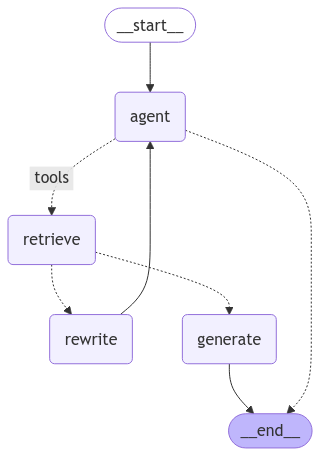

In [45]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
graph.invoke({"messages":"What is machine learning"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='cf4341ac-c138-4f12-8549-9609d655a586'),
  AIMessage(content='Machine learning is a method of teaching computers to make and improve predictions or take actions without being explicitly programmed to do so. It involves algorithms that can learn patterns from data and use this learning to make decisions or predictions on new data. Machine learning is a core component of artificial intelligence and is used in a wide range of applications, from recommendation systems and image recognition to natural language processing and autonomous driving. Would you like to know more about any specific aspect of machine learning?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 183, 'total_tokens': 277, 'completion_time': 0.47, 'prompt_time': 0.011521832, 'queue_time': 0.235460069, 'total_time': 0.481521832}, 'model_name': 'qwen-2.5-32b', 'sys

In [49]:
inputs={
    "messages": [
        ("user", "What is MAchine LEarning"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='It seems like there might have been a small typo in your question. I assume you\'re asking about "Machine Learning." Machine Learning is a method of teaching computers to learn from data, without being explicitly programmed. It involves algorithms that can learn patterns from data and make predictions or decisions. Would you like more detailed information on specific aspects of Machine Learning, such as types of Machine Learning, applications, or the process of creating a Machine Learning model?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 185, 'total_tokens': 275, 'completion_time': 0.45, 'prompt_time': 0.011526565, 'queue_time': 0.22812938600000002, 'total_time': 0.461526565}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-31012478-b4c3-4b8e-b4ad-ae1b91f564a7-0', usage_metadata={'input_tokens': 18